# Preprocesamiento del audio

Los audios se trabajarán en forma de espectogramas para posteriormente entrenar redes convolucionales, por esta razón se recibe audio desde el microfono usado por el dispositivo a disposición del usuario, se guarda como un archivo .wav y con ayuda de la librería librosa se convierte en un spectograma.

In [2]:
import librosa
import os, glob, pickle
import numpy as np

import os #para interactuar con las carpetas y archivos
import pandas as pd
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.stats import zscore

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
#from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from tensorflow.keras.optimizers import Adam, SGD

# Recibir audio desde el dispositivo en uso
tomado de: [link](https://colab.research.google.com/github/facebookresearch/WavAugment/blob/master/examples/python/WavAugment_walkthrough.ipynb#scrollTo=eWq35hN4S6Ga)

In [11]:
!apt-get install libsox-fmt-all libsox-dev sox > /dev/null
! python -m pip install torchaudio > /dev/null
! python -m pip install git+https://github.com/facebookresearch/WavAugment.git > /dev/null

  Running command git clone -q https://github.com/facebookresearch/WavAugment.git /tmp/pip-req-build-h3dw2n01


In [12]:
!pip install ffmpeg-python > /dev/null

In [13]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
import ffmpeg
import tempfile
import pathlib
import torchaudio


AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  #with tempfile.TemporaryDirectory() as tmpdirname:
  #path = pathlib.Path(tmpdirname) / 'tmp.wav'
  path = '/content/'+ 'tmp.wav'
  with open(path, 'wb') as f:
      f.write(riff)
      
  x, sr = torchaudio.load(path)

  return x, sr

In [14]:
x, sr = get_audio()

# Audio a espectograma


In [15]:
%matplotlib inline
import os
import pandas as pd
from glob import glob
import numpy as np

import librosa
import librosa.display
import pylab
import matplotlib.pyplot as plt
from matplotlib import figure
import gc


In [16]:
def create_spectrogram(filename,name):
    plt.interactive(False)
    clip, sample_rate = librosa.load(filename, sr=None)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    filename  =  name + '.jpg'
    plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del filename,name,clip,sample_rate,fig,ax,S

In [17]:
create_spectrogram('/content/tmp.wav','test')

In [18]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from numpy import expand_dims
from tensorflow.keras.applications.vgg16 import preprocess_input

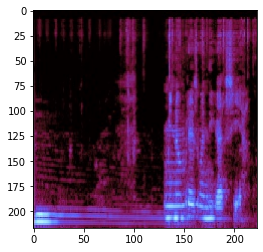

In [19]:
import cv2 as cv
from matplotlib import pyplot as plt
image1 = cv.imread('/content/test.jpg')
plt.imshow(image1)
plt.show()

In [20]:
img1 = load_img('/content/test.jpg', target_size=(223, 217))
img1 = img_to_array(img1)
img1 = expand_dims(img1, axis=0)
img1 = preprocess_input(img1)


In [21]:
n=np.array(img1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


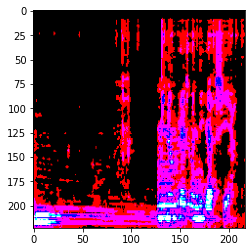

In [22]:
plt.figure()
plt.imshow(n[0])
plt.grid(False)
plt.show()